#Description
This data wrangling will be broken up into many parts.
1. PCPAO_SalesDATA

*   1.1 Import Data
*   1.2 Drop data that isn't single-family home(or condos in the future).
*   1.3 Convert sales_date into datetime type
*   1.4 Limit data to most recent sale of each property
*   1.5 Address Concerns
*   1.5.1 Dropping address data except for STR_CITY and STR_ZIP
*   1.5.2 Cleaning some city and zip values
*   1.5.3 Examining the number of city/zip combinations
*   1.5.4 Dropping parcels where the city/zip combination had less than 30 sales
*   1.6 Dropping Owner Names and Resetting the index
*   1.7 Frontage, View, Landsize, Acreage, and QU_FLG are dropped
*   1.8 PCPAO_SalesDATA.info() check and
*   1.9 House Features are cleaned and converted to categories
*   1.10 County Designations are considered
*   1.10.1 Designated Local Historical Landmark records are dropped.
*   1.10.2 NBORHOOD_CD is dropped.
*   1.10.3 Tax District Description is dropped
*   1.11 Subdivisions
*   1.11.1 Getting a count of unique subdivisions
*   1.11.2 Finding the number of subdivisions with 10 parcels or less
*   1.11.3 Thinking About a Subdivision_Size category
*   1.11.4 Find the number of parcels with no subdivision info
*   1.11.5 Final Subdivision Thoughts
*   1.12 Examining dataset and dropping rows with missing values
*   Dropping Parcel Number and Site Address Columns
*   Converting Site_Cityzip and remaining object columns to categories
*   Dropping sales data prior to 1970
*   Making a dataframe of 2016-to-present sales

Future steps will be done to this data set involve its pairing with the data sets below.

2. PinellasCrimeDATA

This data is a collection of csv files downloaded from [Pinellas Crime Viewer](https://egis.pinellas.gov/apps/CrimeViewer/). The goal with this data is to generate totals and average yearly crime stats relative to each ZIP code and possibly neighborhood code.

3. School_gradeDATA

This data is yet to be collected from the FL DOE website.


4. Exporting the data

####CHANGES TO MAKE
PCPAO_SalesDATA
* Renumber the Description above

crime_data changes

* crime_data was run with all 2016 to 2024 data. How did that go?
* IN crime_data, when going to add new data from 2016 to 2020, separate the cleaning process? You will have done the 2020-2024 cleaning. Don't know how that might mess up the 2016-2020 data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display

#1. PCPAO_SalesDATA


##1.1 Importing Data


Import the data from the csv.

In [2]:
PCPAO_SalesDATA = pd.read_csv('/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PCPAOSalesDATA.csv',low_memory=False)

In [3]:
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155164 entries, 0 to 1155163
Data columns (total 54 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   PARCEL_NUMBER        1155164 non-null  object 
 1   OWNER1               1155134 non-null  object 
 2   OWNER2               624705 non-null   object 
 3   SITE_ADDRESS         1155160 non-null  object 
 4   SITE_CITYZIP         1155164 non-null  object 
 5   SUBDIVISION          1147546 non-null  object 
 6   LAND_SIZE            760559 non-null   object 
 7   TOTAL_LIVING_SQFT    1155156 non-null  float64
 8   TOTAL_GROSS_SQFT     1155156 non-null  float64
 9   NBORHOOD_CD          1155164 non-null  float64
 10  YEAR_BUILT_BLD1      1155098 non-null  float64
 11  TOTAL_LIVING_UNITS   1155156 non-null  float64
 12  ACREAGE              1155164 non-null  float64
 13  CNTY_JST_VALUE       1155164 non-null  int64  
 14  CNTY_ASD_VALUE       1155164 non-null  int64  
 15

##1.2 PROPERTY_USE and PARCEL_TYPE


In [4]:
PCPAO_SalesDATA = PCPAO_SalesDATA[PCPAO_SalesDATA['PROPERTY_USE'] == '0110 Single Family Home']


In [5]:
PCPAO_SalesDATA[['PROPERTY_USE','PARCEL_TYPE']].value_counts(dropna=False)

,,count
PROPERTY_USE,PARCEL_TYPE,
0110 Single Family Home,Residential,703484


Since all of the data is '0110 Single Family Home', dropping the PROPERTY_USE and PARCEL_TYPE columns.

In [6]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['PROPERTY_USE','PARCEL_TYPE'],axis=1)

##1.3 Converting the SALES_DATE to a datetime data type.

In [7]:
PCPAO_SalesDATA['SALES_DATE'] = pd.to_datetime(PCPAO_SalesDATA['SALES_DATE'],format='%m/%d/%Y %I:%M:%S %p')


###1.3.2 Creating a SALES_YEAR column

In [8]:
PCPAO_SalesDATA['SALES_YEAR'] = PCPAO_SalesDATA['SALES_DATE'].dt.year

##1.4 Address Concerns

###1.4.1 Dropping Owner Names
Owner Names are too unique and don't inform about the parcel.

In [9]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['OWNER1','OWNER2'],axis=1)

###1.4.2 Dropping Address columns execept for STR_CITY and STR_ZIP

From previous exploration, SITE_ADDRESS and SITE_CITYZIP matchup well enough with all of the STR_PFX, STR_NUM, STR_NAME, STR_SFX, STR_SFX_DIR, STR_CITY, and STR_ZIP, that I am not concerned with address issues. I will drop all of the address data except for STR_CITY and STR_ZIP as those will enable me to merge crime_data to this set later.

In [10]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['STR_PFX','STR_NUM','STR_NAME','STR_SFX','STR_SFX_DIR','SITE_ADDRESS','SITE_CITYZIP'],axis=1)

###1.4.3 Cleaning Some null STR_ZIP and STR_CITY values
Also renaming STR_ZIP to ZIP and STR_CITY to CITY


In [11]:
PCPAO_SalesDATA.rename(columns={'STR_ZIP':'ZIP','STR_CITY':'CITY'},inplace=True)

In [12]:
PCPAO_SalesDATA[['ZIP','CITY']].nunique()

,0
ZIP,51
CITY,27


I want a list of the cities. I do not want additional state names in them.

In [13]:
print(PCPAO_SalesDATA['CITY'].unique())

['TARPON SPRINGS' 'PALM HARBOR' 'CLEARWATER' 'INDIAN ROCKS BEACH' 'LARGO'
 'ST PETERSBURG' 'CRYSTAL BEACH' 'SEMINOLE' 'OLDSMAR' 'SAFETY HARBOR'
 'MADEIRA BEACH' 'REDINGTON BEACH' 'KENNETH CITY' 'BELLEAIR BLUFFS'
 'NORTH REDINGTON BEACH' 'ST PETE BEACH' 'PINELLAS PARK' 'DUNEDIN'
 'INDIAN SHORES' 'TREASURE ISLAND' 'TIERRA VERDE' 'BELLEAIR' 'GULFPORT'
 'SOUTH PASADENA' 'BELLEAIR BEACH' 'BELLEAIR SHORE' 'REDINGTON SHORES' nan]


In [14]:
PCPAO_SalesDATA[PCPAO_SalesDATA['CITY'].isnull()]['PARCEL_NUMBER']

,PARCEL_NUMBER
1132323,36-29-15-94104-004-0030
1132324,36-29-15-94104-004-0030
1132325,36-29-15-94104-004-0030
1132326,36-29-15-94104-004-0030


I want a list of the zip codes. Every single zip should only be 5 digits for my purposes.

In [15]:
print(PCPAO_SalesDATA['ZIP'].unique())

['34689' '34683' '33763' '33765' '33755' '33785' '33771' '33762' '33709'
 '33710' '33714' '33703' '33704' '33713' '33705' '33712' '34681' '33708'
 '34688' '34677' '34695' '33778' '33770' '33701' '33711' '34684' '34685'
 '33759' '33774' '33760' '34690' '33767' '33786' '33764' '33706' '33773'
 '33702' '33756' '33715' '34698' '33713-3413' '33765-2423' '33777' '33761'
 '33782' '33716' '33776' '33707' '33772' '33781' '33756-1667' nan]


In [16]:
temp_index = PCPAO_SalesDATA[PCPAO_SalesDATA['ZIP'].str.len()>5].index
PCPAO_SalesDATA.loc[temp_index,'ZIP'] = PCPAO_SalesDATA.loc[temp_index,'ZIP'].str[:5]

I want to see if there are a lot of parcels with no zip.

In [17]:
PCPAO_SalesDATA[PCPAO_SalesDATA['ZIP'].isnull()][['PARCEL_NUMBER','CITY','ZIP']]

,PARCEL_NUMBER,CITY,ZIP
1132323,36-29-15-94104-004-0030,NaN,NaN
1132324,36-29-15-94104-004-0030,NaN,NaN
1132325,36-29-15-94104-004-0030,NaN,NaN
1132326,36-29-15-94104-004-0030,NaN,NaN


Only one parcel without city or zip. Looking up the parcel number gives an address of LARGO and 33771

In [18]:
temp_index = PCPAO_SalesDATA[PCPAO_SalesDATA['ZIP'].isnull()].index
PCPAO_SalesDATA.loc[temp_index,'ZIP'] = '33771'
PCPAO_SalesDATA.loc[temp_index,'CITY'] = 'LARGO'

##1.5 Parcel Features Columns

Parcel Features are contamination, subsidence, waterfront, seawall, pool, living units, and total living units.

Contamination, subsidence, waterfront, seawall, and pool should all be Y/N options.

I selected '0110 Single-family housing' for the property_use in 1.2, so living units and total living units should be 1 for each parcel.

###1.5.1 Checking the Y/N columns

Are the YN columns all YN? They should be. If they aren't that will be fixed.
Once they are, I will drop the YN from their names.

In [19]:
yn_cols = ['CONTAMINATION_YN','SUBSIDENCE_YN','POOL','WATERFRONT_YN','SEAWALL']
for col in yn_cols:
  print(col,PCPAO_SalesDATA[col].unique())

CONTAMINATION_YN ['N' 'Y']
SUBSIDENCE_YN ['N' 'Y']
POOL ['N' 'Y']
WATERFRONT_YN ['N' 'Y']
SEAWALL ['No' nan 'Yes']


###1.5.2 Seawall cleaning
I will convert the 'No' to N and the 'Yes' to Y for these values. I will drop the NaN values for SEAWALL

In [20]:
PCPAO_SalesDATA['SEAWALL'].value_counts(dropna=False)

,count
SEAWALL,
No,653007
Yes,49963
NaN,514


In [21]:
PCPAO_SalesDATA.drop(PCPAO_SalesDATA[PCPAO_SalesDATA['SEAWALL'].isnull()].index,inplace=True)
PCPAO_SalesDATA.loc[PCPAO_SalesDATA['SEAWALL']=='No','SEAWALL'] = 'N'
PCPAO_SalesDATA.loc[PCPAO_SalesDATA['SEAWALL']=='Yes','SEAWALL'] = 'Y'

###1.5.3 Renaming Contamination, Subsidence and Waterfront columns

In [22]:
PCPAO_SalesDATA.rename(columns={'CONTAMINATION_YN':'CONTAMINATION','SUBSIDENCE_YN':'SUBSIDENCE','WATERFRONT_YN':'WATERFRONT'},inplace=True)

###1.5.4 Living units and Total Living units
These should both be one right? I selected for single-family housing.

In [23]:
for col in ['LIVING_UNITS','TOTAL_LIVING_UNITS']:
  print(PCPAO_SalesDATA[col].value_counts(dropna=False))

LIVING_UNITS
1.0    702457
2.0       504
0.0         5
3.0         4
Name: count, dtype: int64
TOTAL_LIVING_UNITS
1.0    702190
2.0       743
3.0        37
Name: count, dtype: int64


This is unexpected. Let's take a look at how living_units and total_living units match up.

In [24]:
PCPAO_SalesDATA.groupby(['TOTAL_LIVING_UNITS','LIVING_UNITS']).size()

TOTAL_LIVING_UNITS  LIVING_UNITS
1.0                 0.0                  5
                    1.0             702185
2.0                 1.0                248
                    2.0                495
3.0                 1.0                 24
                    2.0                  9
                    3.0                  4
dtype: int64

###1.5.5 Dropping records that don't have only one for Total_Living_units and Living_units

In [25]:
temp_index = PCPAO_SalesDATA[(PCPAO_SalesDATA['TOTAL_LIVING_UNITS']!=1)|(PCPAO_SalesDATA['LIVING_UNITS']!=1)].index
PCPAO_SalesDATA.drop(temp_index,inplace=True)

###1.5.6 Dropping the 'TOTAL_LIVING_UNITS' and 'LIVING_UNITS' columns since all values are now 1.

In [26]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['TOTAL_LIVING_UNITS','LIVING_UNITS'],axis=1)

##1.6 County Designations(Historic Land, Neighborhood code, Tax District, Special Assessment)

###1.6.1 Designated Local Historical Landmark records and column are dropped
DLHL_YN is for whether the property is a designated local historical landmark. 276 records are for properties that are a designated local historical landmark and 701909 rows are not.


In [27]:
PCPAO_SalesDATA['DLHL_YN'].value_counts()

,count
DLHL_YN,
N,701909
Y,276


In [28]:
PCPAO_SalesDATA.drop(PCPAO_SalesDATA[PCPAO_SalesDATA['DLHL_YN']=='Y'].index,inplace=True)

In [29]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['DLHL_YN'],axis=1)

###1.6.2 NBORHOOD_CD is dropped.
NBORHOOD_CD is the Property Appraiser's atttempt to say which properties make good sales comparisons with each other.

NBORHOOD_CD is currently a float when it should be categorical.

[Neighborhood Code ](https://www.pcpao.gov/learn-about/glossary-terms/n)- This code identifies the appraisal "neighborhood" for purposes of establishing the sales comparison approach to value. It may not correspond with your particular subdivision or geographic neighborhood; it is strictly developed for use in the mass appraisal process. When establishing the sales comparison approach to value we use an appraisal area model to obtain an estimate of value. The model can include hundreds of sales. We then review a subset of sales more closely identified with a particular property, referred to as the appraisal neighborhood. We give the greatest emphasis to sales within the appraisal neighborhood through use of a neighborhood "factor." Through statistical analysis of all of these sales, we establish sales comparison values that account for different property characteristics (such as location, size, amenities, construction quality, view, etc.).

In [30]:
PCPAO_SalesDATA= PCPAO_SalesDATA.drop(['NBORHOOD_CD'],axis=1)

###1.6.3 TAX_DIST_DSCR
TAX_DIST_DSCR is the description of the tax district. Going to drop that.

In [31]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['TAX_DIST_DSCR'],axis=1)

###1.6.4 SPECIAL_ASSESSMENT
This is a code indicating something about how taxes are assessed on the property. They might not apply after a sale so I will drop the column.


In [32]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['SPECIAL_ASSESSMENT'],axis=1)

##1.7 Frontage, Views, Landsize, Acreage, and QU_FLG columns are dropped

###1.7.1 FRONTAGE and VIEWS dropped
FRONTAGE and VIEWS are two columns containing a lot of null data. Going to drop them.

In [33]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['FRONTAGE','VIEWS'],axis=1)

###1.7.2 LAND_SIZE dropped
LAND_SIZE is the description of each lot's length and width. This might be nice to have in the future to create a measure of the lot's squareness, but for now will be dropped.

In [34]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['LAND_SIZE'],axis=1)

###1.7.3 ACREAGE dropped
LAND_AREA_SF and ACREAGE are 100% correlated from previous exploration, so I will just drop the ACREAGE column as the LAND_AREA_SF might be useful if I want to create ratios of total_living_sqft to land_area_sf.

In [35]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['ACREAGE'],axis=1)

###1.7.4 QU_FLG dropped
Also going to drop the QU_FLG as all of the sales should be qualified.

In [36]:
PCPAO_SalesDATA['QU_FLG'].value_counts()

,count
QU_FLG,
Q,701909


In [37]:
PCPAO_SalesDATA= PCPAO_SalesDATA.drop(['QU_FLG'],axis=1)

##1.8 House Features are cleaned and converted to categories

Many features of the built property are recorded as string objects. Lucky most of them are non-null.


Going to convert the following columns to categories.
*  COOLING
*  EXTERIOR_WALLS
*  FLOOR_FINISH
*  FLOOR_SYSTEM
*  FOUNDATION
*  INTERIOR_FINISH
*  ROOF_COVER
*  ROOF_FRAME

YEAR_BUILT_BLD1 and EFFECTIVE_AGE are numerical features of the built property.
As they are numeric, I won't have to categorize them. YEAR_BUILT_BLD1 is a year so technically categorical, but if I subtract the year built from the current year, I can rename the column REAL_AGE or something like that.


COOLING needs some nan values converted into 'No Central Cooling'

###1.8.1 Rework COOLING

Since COOLING has 'Cooling (Central)' or NaN, I will rename the column CENTRAL_COOLING and adjust the values to Y or N

In [38]:
PCPAO_SalesDATA['COOLING'].value_counts(dropna=False)

,count
COOLING,
Cooling (Central),687812
NaN,14097


In [39]:
PCPAO_SalesDATA.loc[PCPAO_SalesDATA['COOLING']=='Cooling (Central)','COOLING'] = 'Y'
PCPAO_SalesDATA.loc[PCPAO_SalesDATA['COOLING'].isnull(),'COOLING'] = 'N'
PCPAO_SalesDATA.rename(columns={'COOLING':'CENTRAL_COOLING'},inplace=True)

### 1.8.2 House feature values cleaning.

Some of the House Features have double spaces in their values.
I want to reduce the spaces down to one space.
Then replace the space with an underscore('_').

In [40]:
col_to_cat = ['CENTRAL_COOLING','EXTERIOR_WALLS','FLOOR_FINISH','FLOOR_SYSTEM','FOUNDATION','INTERIOR_FINISH','ROOF_COVER','ROOF_FRAME']
for col in col_to_cat:
  print(col,PCPAO_SalesDATA[col].unique())

CENTRAL_COOLING ['Y' 'N']
EXTERIOR_WALLS ['Cb Stucco/Cb Reclad' 'Frame  Stucco' 'Concrete Block'
 'Frame/Reclad Alum/Viny' 'Frame/Custom Wood' 'Frame  Siding'
 'Frame/Brick/Stone/Icf/Sip' 'Frame  Metal' 'Masonry Brick'
 'Masonry Stone' 'Frame  Compos']
FLOOR_FINISH ['Carpet/Hardtile/Hardwood' 'Carpet/ Vinyl/Asphalt'
 'Hard Tile/Wood/Marble' 'Concrete Finish' 'Carpet/Vinyl/Asphalt/S']
FLOOR_SYSTEM ['Slab On Grade' 'Slab Above Grade Low' 'Wood' 'Slab Above Grade High']
FOUNDATION ['Continuous Footing Poured' 'Piers' 'Wood/Block Above Ground Footing'
 'Wood Piles Below Ground Footing' 'Concrete Piles Below Ground Footing'
 'Helical Piles Screw Piles Footing']
INTERIOR_FINISH ['Drywall/Plaster' 'Upgrade' 'Wood/Wallboard' 'Custom' 'Mh Average']
ROOF_COVER ['Shingle Composition' 'Concrete Tile/Metal' 'Bu Tar & Gravel  Alt'
 'Metal  Corrugated/She' 'Metal Shingle' 'Roll Composition'
 'Clay Tile/Glazed' 'Slate/Good Metal' 'Asbestos/Wood Shgl'
 'Solar Roof Tiles' 'Mh Roof Over (Metal/Membrane)'

You can see some of the double spaces present above.

In [41]:
for col in col_to_cat:
  PCPAO_SalesDATA[col] = PCPAO_SalesDATA[col].str.replace('  ',' ')

In [42]:
for col in col_to_cat:
  PCPAO_SalesDATA[col] = PCPAO_SalesDATA[col].str.replace(' ','_')

String replacement is done.

In [43]:
for col in col_to_cat:
  print(col,PCPAO_SalesDATA[col].unique())

CENTRAL_COOLING ['Y' 'N']
EXTERIOR_WALLS ['Cb_Stucco/Cb_Reclad' 'Frame_Stucco' 'Concrete_Block'
 'Frame/Reclad_Alum/Viny' 'Frame/Custom_Wood' 'Frame_Siding'
 'Frame/Brick/Stone/Icf/Sip' 'Frame_Metal' 'Masonry_Brick' 'Masonry_Stone'
 'Frame_Compos']
FLOOR_FINISH ['Carpet/Hardtile/Hardwood' 'Carpet/_Vinyl/Asphalt'
 'Hard_Tile/Wood/Marble' 'Concrete_Finish' 'Carpet/Vinyl/Asphalt/S']
FLOOR_SYSTEM ['Slab_On_Grade' 'Slab_Above_Grade_Low' 'Wood' 'Slab_Above_Grade_High']
FOUNDATION ['Continuous_Footing_Poured' 'Piers' 'Wood/Block_Above_Ground_Footing'
 'Wood_Piles_Below_Ground_Footing' 'Concrete_Piles_Below_Ground_Footing'
 'Helical_Piles_Screw_Piles_Footing']
INTERIOR_FINISH ['Drywall/Plaster' 'Upgrade' 'Wood/Wallboard' 'Custom' 'Mh_Average']
ROOF_COVER ['Shingle_Composition' 'Concrete_Tile/Metal' 'Bu_Tar_&_Gravel_Alt'
 'Metal_Corrugated/She' 'Metal_Shingle' 'Roll_Composition'
 'Clay_Tile/Glazed' 'Slate/Good_Metal' 'Asbestos/Wood_Shgl'
 'Solar_Roof_Tiles' 'Mh_Roof_Over_(Metal/Membrane)']
ROOF

###1.8.3 Converting the House Features to Categories

In [44]:
col_to_cat = ['CENTRAL_COOLING','EXTERIOR_WALLS','FLOOR_FINISH','FLOOR_SYSTEM','FOUNDATION','INTERIOR_FINISH','ROOF_COVER','ROOF_FRAME']
for col in col_to_cat:
  PCPAO_SalesDATA[col] = PCPAO_SalesDATA[col].astype('category')

###1.8.4 YEAR_BUILT_BLD1 column turned into REAL_AGE column



In [45]:
PCPAO_SalesDATA.drop(PCPAO_SalesDATA[PCPAO_SalesDATA['YEAR_BUILT_BLD1'].isnull()].index,inplace=True)

In [46]:
PCPAO_SalesDATA['REAL_AGE'] = 2024 - PCPAO_SalesDATA['YEAR_BUILT_BLD1']

In [47]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['YEAR_BUILT_BLD1'],axis=1)

##1.9 PCPAO_SalesDATA.info() Check
With minor exceptions, we have only dropped columns of data from the data set*. We will now narrow down the rows that we want in the data.

* Exceptions are narrowing by property_use, seawall, living_units/total_living_units DLHL_YN, and REAL_AGE.

The only column with null values remaining is SUBDIVISION. Before considering subdivisions, I want to make sure that I have only the most recent sales.

In [48]:
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 701861 entries, 0 to 1155163
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PARCEL_NUMBER        701861 non-null  object        
 1   SUBDIVISION          695258 non-null  object        
 2   TOTAL_LIVING_SQFT    701861 non-null  float64       
 3   TOTAL_GROSS_SQFT     701861 non-null  float64       
 4   CNTY_JST_VALUE       701861 non-null  int64         
 5   CNTY_ASD_VALUE       701861 non-null  int64         
 6   CNTY_TAXABLE_VALUE   701861 non-null  int64         
 7   JUST_LAND            701861 non-null  int64         
 8   JUST_BUILDING        701861 non-null  int64         
 9   JUST_EXTRA_FEATURES  701861 non-null  int64         
 10  SALES_DATE           701861 non-null  datetime64[ns]
 11  PRICE                701861 non-null  int64         
 12  SEAWALL              701861 non-null  object        
 13  CONTAMINATION     

##1.10 Limiting the data to the most recent sale of each Parcel

I want to keep the sales data for only the most recent sale of each property.

###1.10.1 Value_counts of PARCEL_NUMBER and SALES_YEAR
Some parcels have been sold multiple times a year. Getting a sense of how prevalent that is.

In [49]:
PCPAO_SalesDATA[['PARCEL_NUMBER','SALES_YEAR']].value_counts()

PARCEL_NUMBER            SALES_YEAR
36-31-16-82944-000-0280  2020          6
01-32-16-49266-005-0290  2022          6
03-29-15-88110-006-0360  2022          6
36-27-15-01779-000-1180  1989          6
27-28-16-68624-000-0390  1995          6
                                      ..
12-31-15-44928-030-0100  1987          1
                         2004          1
                         2007          1
12-31-15-44928-030-0110  1984          1
36-31-16-95814-000-0050  1978          1
Name: count, Length: 659443, dtype: int64

In [50]:
PCPAO_SalesDATA[['PARCEL_NUMBER','SALES_YEAR']].value_counts().sum()

701861

According to our data, that first parcel(36-31-16-82944-000-0280) was sold 6 times in the 2020. Checking online, I see it was sold [3 times in 2020.](https://www.pcpao.gov/property-details?s=163136829440000280&xmin=-9200928.10920421&ymin=3216862.658740335&xmax=-9200802.853995789&ymax=3216939.245059668&basemap=BaseMapParcelAerials&sales=&scale=564.248588&parcel=36-31-16-82944-000-0280)
Similar things are true for other parcels. We have some duplicates.

In [51]:
PCPAO_SalesDATA[(PCPAO_SalesDATA['PARCEL_NUMBER']=='36-31-16-82944-000-0280')]

,PARCEL_NUMBER,SUBDIVISION,TOTAL_LIVING_SQFT,TOTAL_GROSS_SQFT,CNTY_JST_VALUE,CNTY_ASD_VALUE,CNTY_TAXABLE_VALUE,JUST_LAND,JUST_BUILDING,JUST_EXTRA_FEATURES,...,EXTERIOR_WALLS,RCN,FLOOR_FINISH,FLOOR_SYSTEM,FOUNDATION,INTERIOR_FINISH,ROOF_COVER,ROOF_FRAME,SALES_YEAR,REAL_AGE
1155095,36-31-16-82944-000-0280,"SMITH'S REPLAT, E.A.",1347.0,1667.0,259712,116636,61636,68707,191005,0,...,Cb_Stucco/Cb_Reclad,279210.0,Carpet/Hardtile/Hardwood,Slab_On_Grade,Continuous_Footing_Poured,Drywall/Plaster,Shingle_Composition,Flat_Shed,2020,73.0
1155096,36-31-16-82944-000-0280,"SMITH'S REPLAT, E.A.",1347.0,1667.0,259712,116636,61636,68707,191005,0,...,Cb_Stucco/Cb_Reclad,279210.0,Carpet/Hardtile/Hardwood,Slab_On_Grade,Continuous_Footing_Poured,Drywall/Plaster,Shingle_Composition,Flat_Shed,2020,73.0
1155097,36-31-16-82944-000-0280,"SMITH'S REPLAT, E.A.",1347.0,1667.0,259712,116636,61636,68707,191005,0,...,Cb_Stucco/Cb_Reclad,279210.0,Carpet/Hardtile/Hardwood,Slab_On_Grade,Continuous_Footing_Poured,Drywall/Plaster,Shingle_Composition,Flat_Shed,2020,73.0
1155098,36-31-16-82944-000-0280,"SMITH'S REPLAT, E.A.",1347.0,1667.0,259712,116636,61636,68707,191005,0,...,Cb_Stucco/Cb_Reclad,279210.0,Carpet/Hardtile/Hardwood,Slab_On_Grade,Continuous_Footing_Poured,Drywall/Plaster,Shingle_Composition,Flat_Shed,2020,73.0
1155099,36-31-16-82944-000-0280,"SMITH'S REPLAT, E.A.",1347.0,1667.0,259712,116636,61636,68707,191005,0,...,Cb_Stucco/Cb_Reclad,279210.0,Carpet/Hardtile/Hardwood,Slab_On_Grade,Continuous_Footing_Poured,Drywall/Plaster,Shingle_Composition,Flat_Shed,2020,73.0
1155100,36-31-16-82944-000-0280,"SMITH'S REPLAT, E.A.",1347.0,1667.0,259712,116636,61636,68707,191005,0,...,Cb_Stucco/Cb_Reclad,279210.0,Carpet/Hardtile/Hardwood,Slab_On_Grade,Continuous_Footing_Poured,Drywall/Plaster,Shingle_Composition,Flat_Shed,2020,73.0
1155101,36-31-16-82944-000-0280,"SMITH'S REPLAT, E.A.",1347.0,1667.0,259712,116636,61636,68707,191005,0,...,Cb_Stucco/Cb_Reclad,279210.0,Carpet/Hardtile/Hardwood,Slab_On_Grade,Continuous_Footing_Poured,Drywall/Plaster,Shingle_Composition,Flat_Shed,2024,73.0
1155102,36-31-16-82944-000-0280,"SMITH'S REPLAT, E.A.",1347.0,1667.0,259712,116636,61636,68707,191005,0,...,Cb_Stucco/Cb_Reclad,279210.0,Carpet/Hardtile/Hardwood,Slab_On_Grade,Continuous_Footing_Poured,Drywall/Plaster,Shingle_Composition,Flat_Shed,2024,73.0


###1.10.2 Dropping Duplicated Rows

In [52]:
PCPAO_SalesDATA.drop_duplicates(keep='last',inplace=True)

In [53]:
PCPAO_SalesDATA[['PARCEL_NUMBER','SALES_YEAR']].value_counts()

PARCEL_NUMBER            SALES_YEAR
14-30-15-84204-002-0080  2021          5
27-31-16-69552-000-0830  1999          4
06-31-17-20160-001-0150  2022          4
23-31-16-65862-002-0030  2021          4
22-31-16-72756-003-0110  2022          4
                                      ..
12-30-15-20062-011-0260  1978          1
                         2024          1
12-30-15-20062-011-0270  1978          1
                         2023          1
36-31-16-95814-000-0050  1978          1
Name: count, Length: 659443, dtype: int64

In [54]:
PCPAO_SalesDATA[['PARCEL_NUMBER','SALES_YEAR']].value_counts().sum()

670921

###1.10.3 Keeping The Most Recent Sales Record

In [55]:
PCPAO_SalesDATA.sort_values(by='SALES_DATE',inplace=True)

In [56]:
PCPAO_SalesDATA.drop_duplicates(subset='PARCEL_NUMBER',keep='last',inplace=True)

In [57]:
PCPAO_SalesDATA.reset_index(drop=True,inplace=True)

In [58]:
PCPAO_SalesDATA.head().T

,0,1,2,3,4
PARCEL_NUMBER,13-31-16-72504-001-0160,05-31-16-46044-013-0120,36-27-15-89334-000-0090,19-30-15-99342-006-0110,29-30-16-71082-083-0030
SUBDIVISION,"POMEROY'S ADD, J.B.",KENNETH CITY UNIT 5,TAMPA & TARPON SPRINGS LAND CO,YACHT CLUB ESTATES UNIT 6,PINELLAS PARK 1ST ADD
TOTAL_LIVING_SQFT,920.0,1898.0,2721.0,1658.0,1350.0
TOTAL_GROSS_SQFT,1238.0,3052.0,3519.0,2180.0,1800.0
CNTY_JST_VALUE,272881,395147,989800,328322,346062
CNTY_ASD_VALUE,267853,306702,749717,274144,346062
CNTY_TAXABLE_VALUE,267853,306702,694717,224144,346062
JUST_LAND,196833,130603,673184,200272,294562
JUST_BUILDING,73143,246251,297644,122436,46514
JUST_EXTRA_FEATURES,2905,18293,18972,5613,4986


##1.11 Examining the Number of CITY/ZIP combinations.

Some City/Zip combinations only have 1 parcel sale listed. Some are errors.

The CITY and ZIP are currently the best location identifiers. There are currently only 83 unique city/zip combinations. Some city/zip combinations have thousands of parcels while some city/zip combinations have only one parcel.

I think the city zip combinations that have only one property need to be checked. The city or zip could be wrong.

In [60]:
PCPAO_SalesDATA['CITY'].value_counts()

,count
CITY,
ST PETERSBURG,73051
CLEARWATER,30009
PALM HARBOR,19584
LARGO,19387
SEMINOLE,18739
PINELLAS PARK,11508
DUNEDIN,9901
TARPON SPRINGS,9375
SAFETY HARBOR,4983


In [61]:
PCPAO_SalesDATA['ZIP'].value_counts()

,count
ZIP,
33710,11526
33713,10038
34683,9640
34698,9511
33703,8299
33756,7099
34689,7013
33772,6940
33707,6723


In [62]:
PCPAO_SalesDATA.groupby(['CITY','ZIP']).size().sort_values().head(20)

,,0
CITY,ZIP,
INDIAN ROCKS BEACH,33786,1
TIERRA VERDE,33773,1
OLDSMAR,34695,1
LARGO,33755,1
PINELLAS PARK,33702,1
TARPON SPRINGS,34683,1
PALM HARBOR,34698,1
TARPON SPRINGS,34690,1
LARGO,33777,5


###1.11.2 Dropping parcels where the city/zip combination had less than 30 sales

There are a handful of city and zip code combinations that don't have 30+ parcel sales. I know from previous work that some of the citys and zips are incorrect. Rather than manually search and fix each parcel, I will just drop the records where the city/zip combination has less than 30 sales.

In [63]:
for index, value in PCPAO_SalesDATA.groupby(['CITY','ZIP']).size().items():
  if value<=30:
    PCPAO_SalesDATA.drop(PCPAO_SalesDATA[(PCPAO_SalesDATA['CITY']==index[0])&(PCPAO_SalesDATA['ZIP']==index[1])].index, inplace=True)

In [64]:
PCPAO_SalesDATA.groupby(['CITY','ZIP']).size().sort_values().head(10)

CITY                   ZIP  
BELLEAIR SHORE         33786     49
SEMINOLE               33708     72
INDIAN SHORES          33785    100
ST PETERSBURG          33716    119
                       33715    181
NORTH REDINGTON BEACH  33708    285
SOUTH PASADENA         33707    300
GULFPORT               33711    339
DUNEDIN                34683    401
LARGO                  33760    444
dtype: int64

In [65]:
PCPAO_SalesDATA.groupby(['CITY','ZIP']).size()

CITY             ZIP  
BELLEAIR         33756    1211
BELLEAIR BEACH   33786     759
BELLEAIR BLUFFS  33770     543
BELLEAIR SHORE   33786      49
CLEARWATER       33755    6168
                          ... 
ST PETERSBURG    33716     119
TARPON SPRINGS   34688    2360
                 34689    7013
TIERRA VERDE     33715     913
TREASURE ISLAND  33706    1519
Length: 69, dtype: int64

Only 69 combinations of City and Zip code now.

##1.12 Subdivisions are examined and Column is dropped

In [66]:
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218749 entries, 0 to 218824
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PARCEL_NUMBER        218749 non-null  object        
 1   SUBDIVISION          216573 non-null  object        
 2   TOTAL_LIVING_SQFT    218749 non-null  float64       
 3   TOTAL_GROSS_SQFT     218749 non-null  float64       
 4   CNTY_JST_VALUE       218749 non-null  int64         
 5   CNTY_ASD_VALUE       218749 non-null  int64         
 6   CNTY_TAXABLE_VALUE   218749 non-null  int64         
 7   JUST_LAND            218749 non-null  int64         
 8   JUST_BUILDING        218749 non-null  int64         
 9   JUST_EXTRA_FEATURES  218749 non-null  int64         
 10  SALES_DATE           218749 non-null  datetime64[ns]
 11  PRICE                218749 non-null  int64         
 12  SEAWALL              218749 non-null  object        
 13  CONTAMINATION      

###1.12.1 Getting a count of the number of unique subdivision.

In [67]:
PCPAO_SalesDATA['SUBDIVISION'].nunique()

6094

In [68]:
PCPAO_SalesDATA['SUBDIVISION'].value_counts().head(20)

,count
SUBDIVISION,
NORTH ST PETERSBURG,776
ORANGE LAKE VILLAGE,691
PINELLAS GROVES,640
"SUTHERLAND, TOWN OF",604
DUNEDIN ISLES NO. 1,540
SHORE ACRES OVERLOOK SEC,536
OLDSMAR REVISED MAP,526
SNELL & HAMLETT'S NORTH SHORE ADD,484
GLENWOOD,478


In [69]:
PCPAO_SalesDATA['SUBDIVISION'].value_counts().tail(20)

,count
SUBDIVISION,
SPEAR & PITTSER REPLAT,1
ANCLOTE SUB,1
FORREST BLUFF BLK 13 REP,1
CHESAPEAKE POINT NO. 2,1
STOVER ACRE,1
PERKINS REPLAT,1
PERKINS OVERLOOK AT SMACKS BAYOU,1
ANDERSON'S ACRE SUB,1
MARTIN'S REPLAT,1


There are a 20 subdivision that have 350+ parcels. There are also at least 20 subdivisions that have only one parcel. There are 6,094 unique subdivisions.

 Let's find the number of subdivisions that have only 10 or less parcels.

###1.12.2 Finding the number of subdivisions that have 10 or less parcels

In [70]:
subdivision_counts = PCPAO_SalesDATA['SUBDIVISION'].value_counts()
print(subdivision_counts.groupby(subdivision_counts.values).size().head(10))
print('Number of subdivision with 10 or less parcels: ',subdivision_counts.groupby(subdivision_counts.values).size().head(10).sum())

1     340
2     328
3     237
4     179
5     185
6     169
7     152
8     162
9     152
10    120
Name: count, dtype: int64
Number of subdivision with 10 or less parcels:  2024


There are 2024 total parcel in a subdivision of size 10 or smaller.

###1.12.3 Thinking about making a Subdivision_Size category
There are roughly 210,000 parcels. I wonder if a subdivision_size category of small(1-20?),Medium(20-100?) and Large(100-1000?) would work well?

If I keep the subdivision column, turning it into category and then eventually dummy variables will make over 6000 dummy variables.

Trying to figure out what a good cut off for the size of each group would be.


In [71]:
#The number of parcels in each subdivision are counted. We find 33% and 67% of the way through the list of subdivisions.
np.quantile(subdivision_counts.values,[.33,.67])
#The results are 10 parcels in a subdivision at 33% and 35 parcels in a subdivision at 67%

array([10., 35.])

In [72]:
#Making a dictionary of {subdivision of given size:total number of parcels in a subdivision of given size}
subdivision_to_total_parcels_dict = {}
#Making a dictionary of {subdivision of given size: total number of parcels in a subdivision of given size or smaller}
subdivision_to_total_parcels_dict_cdf = {}
parcel_sum = 0
for index, value in subdivision_counts.groupby(subdivision_counts.values).size().items():
  parcel_sum += value*index
  subdivision_to_total_parcels_dict[index] = value*index #index is size of subdivision, value*index gives the number of parcels in a subdivision of that size
  subdivision_to_total_parcels_dict_cdf[index] = parcel_sum


In [73]:
#list(subdivision_to_total_parcels_dict.values()) gives a list of the number of parcels in a subdivision but loses size of subdivision.
#the list is also unordered going [336, 660, 702, 724, 925, 1050, 1050, 1304, 1368, 1200, 1485, 1440, 1534, 1890, 1590,...]
np.quantile(list(subdivision_to_total_parcels_dict.values()),[0.33,0.67])
#Not super useful

array([ 379.44, 1092.  ])

In [74]:
#list(subdivision_to_total_parcels_dict_cdf.values()) gives a list of the number of parcels in a subdivision of size N or less.
#This list is growing in an ordered manner
#dict_values([336, 996, 1698, 2422, 3347, 4397, 5447, 6751, 8119, 9319, 10804,...]
np.quantile(list(subdivision_to_total_parcels_dict_cdf.values()),[0.33,0.67])
#So quantile should say when 33% of the parcels are in a subdivision and when 67% of the parcels are in a subdivision

array([131504.36, 187273.04])

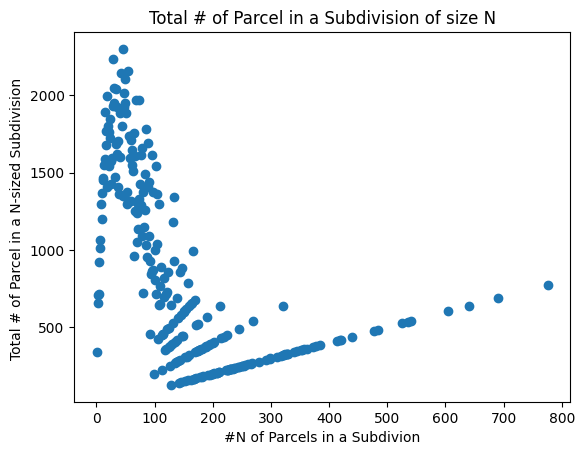

In [75]:
x = subdivision_to_total_parcels_dict.keys()
y = subdivision_to_total_parcels_dict.values()
plt.scatter(x,y)
plt.title('Total # of Parcel in a Subdivision of size N')
plt.xlabel('#N of Parcels in a Subdivion')
plt.ylabel('Total # of Parcel in a N-sized Subdivision ')
plt.show()


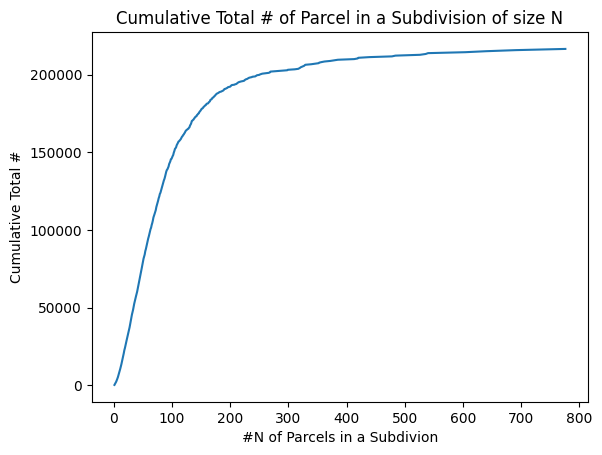

In [76]:
x=subdivision_to_total_parcels_dict_cdf.keys()
y=subdivision_to_total_parcels_dict_cdf.values()
plt.plot(x,y)
plt.title('Cumulative Total # of Parcel in a Subdivision of size N')
plt.xlabel('#N of Parcels in a Subdivion')
plt.ylabel('Cumulative Total #')
plt.show()

###1.12.4 Checking how many records have a null subdivision

In [77]:
PCPAO_SalesDATA['SUBDIVISION'].isnull().sum()

2176

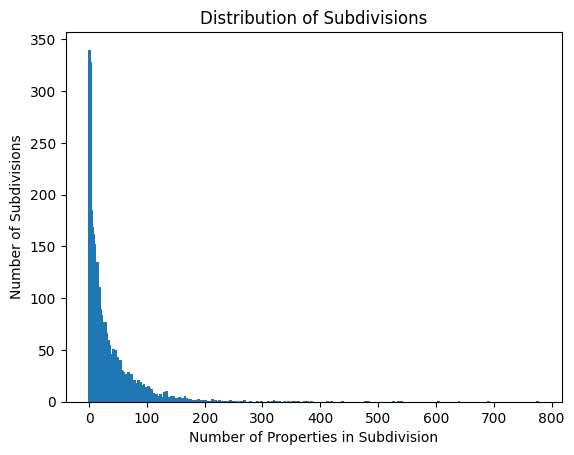

In [78]:
x=subdivision_counts.groupby(subdivision_counts.values).size().index
y=subdivision_counts.groupby(subdivision_counts.values).size().values

plt.bar(x=x,height=y,width=5)
plt.title('Distribution of Subdivisions')
plt.xlabel('Number of Properties in Subdivision')
plt.ylabel('Number of Subdivisions')
plt.show()

###1.12.5 Final Subdivision Thoughts

Thinking about SUBDIVISION here. There are 6,094 named subdivisions. These subdivisions cover all but 2176 properties. 340 properties are their own subdivision.

Going to drop this column for now. I hoped it would work as a replacement for the neighborhood column. Maybe it could.

I could create a subdivision_size column that categorizes the properties by the size of the subdivision. Not sure of the benefit. I am not sure where the NaN subdivision properties would fall, but a 'No listed subdivision' would be the largest subdivision category.

In [79]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['SUBDIVISION'],axis=1)

##1.13 PCPAO_SalesDATA.info() Check
We have now dropped records to only 218749 entries.
Records dropped involved unique/rare CITY/ZIP combinations and the non-most-recent sales

In [80]:
PCPAO_SalesDATA.reset_index(drop=True,inplace=True)
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218749 entries, 0 to 218748
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PARCEL_NUMBER        218749 non-null  object        
 1   TOTAL_LIVING_SQFT    218749 non-null  float64       
 2   TOTAL_GROSS_SQFT     218749 non-null  float64       
 3   CNTY_JST_VALUE       218749 non-null  int64         
 4   CNTY_ASD_VALUE       218749 non-null  int64         
 5   CNTY_TAXABLE_VALUE   218749 non-null  int64         
 6   JUST_LAND            218749 non-null  int64         
 7   JUST_BUILDING        218749 non-null  int64         
 8   JUST_EXTRA_FEATURES  218749 non-null  int64         
 9   SALES_DATE           218749 non-null  datetime64[ns]
 10  PRICE                218749 non-null  int64         
 11  SEAWALL              218749 non-null  object        
 12  CONTAMINATION        218749 non-null  object        
 13  SUBSIDENCE    

##1.14 Reducing sales data to 2016 to present

###1.14.1 Making a dataframe of data from 2016 to present

In [81]:
sales16 = PCPAO_SalesDATA[PCPAO_SalesDATA['SALES_DATE'].dt.year>=2016].reset_index(drop=True)
sales16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85249 entries, 0 to 85248
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   PARCEL_NUMBER        85249 non-null  object        
 1   TOTAL_LIVING_SQFT    85249 non-null  float64       
 2   TOTAL_GROSS_SQFT     85249 non-null  float64       
 3   CNTY_JST_VALUE       85249 non-null  int64         
 4   CNTY_ASD_VALUE       85249 non-null  int64         
 5   CNTY_TAXABLE_VALUE   85249 non-null  int64         
 6   JUST_LAND            85249 non-null  int64         
 7   JUST_BUILDING        85249 non-null  int64         
 8   JUST_EXTRA_FEATURES  85249 non-null  int64         
 9   SALES_DATE           85249 non-null  datetime64[ns]
 10  PRICE                85249 non-null  int64         
 11  SEAWALL              85249 non-null  object        
 12  CONTAMINATION        85249 non-null  object        
 13  SUBSIDENCE           85249 non-

###1.14.2 Counts of sales per year

In [82]:
sales16['SALES_DATE'].dt.year.value_counts().sort_index()

,count
SALES_DATE,
2016,7658
2017,8544
2018,9365
2019,10160
2020,10993
2021,12501
2022,10339
2023,9306
2024,6383


###1.14.3 Dropping PCPAO data that has a sales date prior to 1970.

In [86]:
PCPAO_SalesDATA = PCPAO_SalesDATA[PCPAO_SalesDATA['SALES_DATE'].dt.year>=1970].reset_index(drop=True)

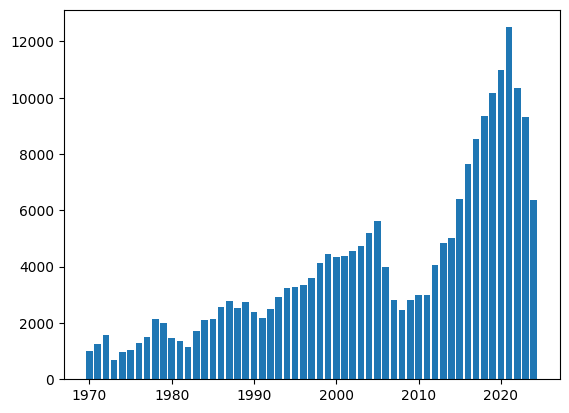

In [87]:
sales_date_count = PCPAO_SalesDATA['SALES_DATE'].dt.year.value_counts().reset_index()
x = sales_date_count['SALES_DATE']
y = sales_date_count['count']
plt.bar(x=x,height=y)
plt.show()


This graph matches one seen in earlier data exploration. Now I will just collect sales since 2016

##1.15 Dropping Identifiers and Making Dummy Variables

###1.15.1 Dropping Parcel Number

All the parcel numbers should be unique identifiers since we limited the records to the most recent sale of each parcel. I am not aware of any rules determining parcel numbers, so I will drop them.


In [88]:
print('Number of Unique sales16 parcels:',sales16['PARCEL_NUMBER'].nunique())
print('Number of Unique PCPAO_SalesDATA parcels:',PCPAO_SalesDATA['PARCEL_NUMBER'].nunique())

KeyError: 'PARCEL_NUMBER'

In [84]:
PCPAO_SalesDATA.drop(['PARCEL_NUMBER'],axis=1,inplace=True)
sales16.drop(['PARCEL_NUMBER'],axis=1,inplace=True)


###1.15.2 Converting Binary object/category columns to dummy variables.

In [89]:
yn_columns = ['CONTAMINATION','SUBSIDENCE','SEAWALL','CENTRAL_COOLING','POOL','WATERFRONT']

sales16 = pd.get_dummies(sales16,prefix = yn_columns,columns=yn_columns,drop_first=True)
PCPAO_SalesDATA = pd.get_dummies(PCPAO_SalesDATA,prefix = yn_columns,columns=yn_columns,drop_first=True)

###1.15.3 Converting Non-binary object/category columns to dummy variables

In [93]:
object_columns = ['EVAC_ZONE','CITY','ZIP','EXTERIOR_WALLS','FLOOR_FINISH','FLOOR_SYSTEM','FOUNDATION','INTERIOR_FINISH','ROOF_COVER','ROOF_FRAME']
sales16 = pd.get_dummies(sales16,prefix = object_columns,columns=object_columns)
PCPAO_SalesDATA = pd.get_dummies(PCPAO_SalesDATA,prefix = object_columns,columns=object_columns)

#2. Crime Data

##2.1 Assembling the files into one dataframe.

This section ends with the creation of a crime_data dataframe

###2.1.1 Trying to Open a csv
I currently have the data for crimes from January 1st, 2020 to July 22nd, 2024.

I am going to start by examining one file just to get a look at the data structure

In [ ]:
try:
  crime_data = pd.read_csv('/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PinellasCrimeDATA_2024/PinellasCrime20200101_20200115.csv', on_bad_lines='error')
  print('File read successfully')
except Exception as e:
  print(e)

Error tokenizing data. C error: Expected 9 fields in line 536, saw 11



###2.1.2 Getting a list of the issues opening the csv files
Some of the csv files have errors where data in a row is recorded in an unlabeled column. I'm going to see if I can get a list of the files that have the issue, as I think these could be quick fixes. The error seems to be repeating of the city/zip in the same record.

In [ ]:
error_list = []
for file in os.listdir('/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PinellasCrimeDATA_2024'):
  try:
    crime_data = pd.read_csv(f'/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PinellasCrimeDATA_2024/{file}', on_bad_lines='error')
  except Exception as e:
    error_list.append((file,e))


In [ ]:
print(len(error_list))

157


In [ ]:
print(error_list[0:5])

[('PinellasCrime20240516_20240531.csv', ParserError('Error tokenizing data. C error: Expected 9 fields in line 375, saw 10\n')), ('PinellasCrime20240616_20240630.csv', ParserError('Error tokenizing data. C error: Expected 9 fields in line 56, saw 11\n')), ('PinellasCrime20240301_20240315.csv', ParserError('Error tokenizing data. C error: Expected 9 fields in line 288, saw 11\n')), ('PinellasCrime20240316_20240331.csv', ParserError('Error tokenizing data. C error: Expected 9 fields in line 108, saw 10\n')), ('PinellasCrime20240601_20240615.csv', ParserError('Error tokenizing data. C error: Expected 9 fields in line 594, saw 11\n'))]


Okay, so there are 92 files with errors in 109 files. That  is more than I want to fix manually. I am going to look up methods to read in the files that have uneven lengths of records.

###2.1.3 Getting the column names

Some suggestions I have seen are to have a function read each line of the file to find the longest row and then use pd.read_csv with header=none, and names=range(len(longest row)).

I feel confident the longest row is a length of 11. I could just read in each file with a given set of names for the columns, skip the header row, and concatenate all of the files.

I will start by trying to just get the names of the columns.

In [ ]:
data_file = '/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PinellasCrimeDATA_2024/PinellasCrime20200101_20200115.csv'
data_file_delimiter = ','
column_names = []
with open(data_file,'r') as temp_f:
  line = temp_f.readline()
  column_names = line.strip().split(data_file_delimiter)
print(column_names)

['AGENCY_ID', ' REPORT_DATE', ' OFFENSE_START_TIME', ' REPORT_KEY', ' REPORT_CODE', ' CATEGORY', ' BLOCK_ADDRESS', ' CITY', ' ZIP']


Alright, we have column names (with whitespace in some of the names). I am going to add 2 extra column names ['EXTRA_1', 'EXTRA_2'], to the column names list.

###2.1.4 Adding 2 extra column names & stripping whitespace from the names

In [ ]:
column_names.extend(['EXTRA_1','EXTRA_2'])

Going to strip the whitespace in the column names. It will only frustrate my typing of column later otherwise.

In [ ]:
col_names = [name.strip() for name in column_names]
print(col_names)

['AGENCY_ID', 'REPORT_DATE', 'OFFENSE_START_TIME', 'REPORT_KEY', 'REPORT_CODE', 'CATEGORY', 'BLOCK_ADDRESS', 'CITY', 'ZIP', 'EXTRA_1', 'EXTRA_2']


###2.1.5 Reading in a file

Going to setup reading in a csv file with the new col_names.

In [ ]:
crime_data = pd.read_csv(data_file,names=col_names,skiprows=1)

In [ ]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079 entries, 0 to 1078
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AGENCY_ID           1079 non-null   object 
 1   REPORT_DATE         1079 non-null   object 
 2   OFFENSE_START_TIME  1079 non-null   object 
 3   REPORT_KEY          1079 non-null   object 
 4   REPORT_CODE         1079 non-null   object 
 5   CATEGORY            1079 non-null   object 
 6   BLOCK_ADDRESS       951 non-null    object 
 7   CITY                1078 non-null   object 
 8   ZIP                 1073 non-null   float64
 9   EXTRA_1             1 non-null      object 
 10  EXTRA_2             1 non-null      float64
dtypes: float64(2), object(9)
memory usage: 92.9+ KB


In [ ]:
crime_data.head(10)

,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2
0,Indian Shores PD,1/4/2020,04:51:00 PM,IS20-282,GTA,STOLEN VEHICLE,19700 Block of GULF BLVD,INDIAN SHORES,33785.0,NaN,NaN
1,Sheriff,1/6/2020,01:00:00PM,SO20-6512,PT,THEFT-PETIT,4000 Block of 54TH AVE N,PINELLAS SO,33714.0,NaN,NaN
2,Sheriff,12/31/2019,01:39:00 AM,SO20-92,AB,BATTERY-AGGRAVATED,200 Block of SCOTLAND ST,DUNEDIN,34698.0,NaN,NaN
3,Sheriff,1/2/2020,08:14:00 PM,SO20-2582,BBD,BATTERY,COUNTY JAIL,PINELLAS SO,33760.0,NaN,NaN
4,Sheriff,1/8/2020,04:40:00 PM,SO20-8930,BRGB,BURGLARY-BUSINESS,6800 Block of SEMINOLE BLVD,SEMINOLE,33772.0,NaN,NaN
5,Sheriff,1/3/2020,07:00:00 PM,SO20-3731,BRGC,BURGLARY-VEHICLE,6200 Block of SEMINOLE BLVD,SEMINOLE,33772.0,NaN,NaN
6,Sheriff,1/6/2020,11:35:00AM,SO20-6611,PT,THEFT-PETIT,7700 Block of SEMINOLE BLVD,SEMINOLE,33772.0,NaN,NaN
7,Sheriff,12/31/2019,12:00:00 PM,SO20-447,BRGC,BURGLARY-VEHICLE,10900 Block of 91ST TERR N,SEMINOLE,33772.0,NaN,NaN
8,Sheriff,12/31/2019,01:39:00 PM,SO20-468,AL,ALARM,9200 Block of SEMINOLE BLVD,SEMINOLE,33772.0,NaN,NaN
9,Sheriff,1/9/2020,01:18:00 PM,SO20-10115,BAT,BATTERY,10600 Block of BLOSSOM LAKE DR,SEMINOLE,33772.0,NaN,NaN


This is looking good. Now to work on concatenating the dataframes.

I will create a crime_data2 dataframe to join to crime_data.

###2.1.6 Reading in a second file

In [ ]:
data_file = '/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PinellasCrimeDATA_2024/PinellasCrime20200116_20200131.csv'
crime_data2 = pd.read_csv(data_file,names=col_names,skiprows=1)

In [ ]:
crime_data2.info()
crime_data2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AGENCY_ID           1004 non-null   object 
 1   REPORT_DATE         1004 non-null   object 
 2   OFFENSE_START_TIME  1004 non-null   object 
 3   REPORT_KEY          1004 non-null   object 
 4   REPORT_CODE         1004 non-null   object 
 5   CATEGORY            1004 non-null   object 
 6   BLOCK_ADDRESS       987 non-null    object 
 7   CITY                1001 non-null   object 
 8   ZIP                 999 non-null    float64
 9   EXTRA_1             0 non-null      float64
 10  EXTRA_2             0 non-null      float64
dtypes: float64(3), object(8)
memory usage: 86.4+ KB


,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2
0,Sheriff,1/25/2020,08:00:00PM,SO20-27847,BRGC,BURGLARY-VEHICLE,17300 Block of GULF BLVD,N REDINGTON BEACH,33708.0,NaN,NaN
1,Sheriff,1/25/2020,02:20:00PM,SO20-26893*1,BRGR,BURGLARY-RESIDENCE,300 Block of 4TH ST S,SAFETY HARBOR,34695.0,NaN,NaN
2,Sheriff,1/25/2020,06:00:00PM,SO20-27423,GTA,STOLEN VEHICLE,WILCOX RD & WASHINGTON DR,PINELLAS SO,33774.0,NaN,NaN
3,Clearwater PD,1/25/2020,10:00:00PM,CW20-13410,PT,THEFT-PETIT,2000 Block of ALPINE RD,CLEARWATER,33755.0,NaN,NaN
4,Largo PD,1/23/2020,10:07:00PM,20000801,0680,THEFT-PETIT,601 Block of ROSERY RD NE,LARGO,33770.0,NaN,NaN


###2.1.7 Combining the two dataframes into one

In [ ]:
result = pd.concat([crime_data,crime_data2],ignore_index=True)

In [ ]:
result.head()
result.info()
result.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083 entries, 0 to 2082
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AGENCY_ID           2083 non-null   object 
 1   REPORT_DATE         2083 non-null   object 
 2   OFFENSE_START_TIME  2083 non-null   object 
 3   REPORT_KEY          2083 non-null   object 
 4   REPORT_CODE         2083 non-null   object 
 5   CATEGORY            2083 non-null   object 
 6   BLOCK_ADDRESS       1938 non-null   object 
 7   CITY                2079 non-null   object 
 8   ZIP                 2072 non-null   float64
 9   EXTRA_1             1 non-null      object 
 10  EXTRA_2             1 non-null      float64
dtypes: float64(2), object(9)
memory usage: 179.1+ KB


,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2
2078,Largo PD,1/20/2020,02:30:00PM,20000669,0680,THEFT-PETIT,2600 Block of ROOSEVELT BLVD,CLEARWATER,33765.0,NaN,NaN
2079,Largo PD,1/21/2020,10:33:00PM,20000730,0810,ASSAULT,600 Block of CLEARWATER LARGO RD N,LARGO,33770.0,NaN,NaN
2080,Largo PD,1/22/2020,10:00:00PM,20000752,0710,STOLEN VEHICLE,8500 Block of ULMERTON RD,LARGO,33771.0,NaN,NaN
2081,Largo PD,1/22/2020,02:30:00PM,20000760,0810,ASSAULT,3000 Block of 19TH PL SW,LARGO,33771.0,NaN,NaN
2082,Largo PD,1/22/2020,09:09:00PM,20000767,4010,TRAFFIC ACCIDENT,ROOSEVELT BLVD/US HIGHWAY 19 N,CLEARWATER,33770.0,NaN,NaN


###2.1.8 Putting all of this work together.

Unexpected, we have a 12th column in one of the files. Easy fix

In [ ]:
col_names.append('EXTRA_3')

In [ ]:
directory = '/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PinellasCrimeDATA_2024'
list_of_dfs = [pd.read_csv(f'{directory}/{file}',names=col_names,skiprows=1) for file in os.listdir(directory)]
crime_data = pd.concat(list_of_dfs,ignore_index=True)
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186026 entries, 0 to 186025
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   AGENCY_ID           186026 non-null  object 
 1   REPORT_DATE         186026 non-null  object 
 2   OFFENSE_START_TIME  186026 non-null  object 
 3   REPORT_KEY          186026 non-null  object 
 4   REPORT_CODE         186026 non-null  object 
 5   CATEGORY            186026 non-null  object 
 6   BLOCK_ADDRESS       170583 non-null  object 
 7   CITY                185657 non-null  object 
 8   ZIP                 178494 non-null  object 
 9   EXTRA_1             327 non-null     object 
 10  EXTRA_2             80 non-null      object 
 11  EXTRA_3             1 non-null       float64
dtypes: float64(1), object(11)
memory usage: 17.0+ MB


##2.2 Cleaning the dataframe

M goal is to make summary statistics.


*   The total # of crimes for each city&zip combination
*   The # of crimes for each city&zip combination out of the total # of crimes in the county(effectively a percentage)
*   The # of crimes for each city
*   The # of crimes for each zip

More will be added as I make progress.



####Info from PINELLAS COUNTY SHERIFF's OFFICE
Report_key

In [ ]:
crime_data.info()
crime_data.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186026 entries, 0 to 186025
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   AGENCY_ID           186026 non-null  object 
 1   REPORT_DATE         186026 non-null  object 
 2   OFFENSE_START_TIME  186026 non-null  object 
 3   REPORT_KEY          186026 non-null  object 
 4   REPORT_CODE         186026 non-null  object 
 5   CATEGORY            186026 non-null  object 
 6   BLOCK_ADDRESS       170583 non-null  object 
 7   CITY                185657 non-null  object 
 8   ZIP                 178494 non-null  object 
 9   EXTRA_1             327 non-null     object 
 10  EXTRA_2             80 non-null      object 
 11  EXTRA_3             1 non-null       float64
dtypes: float64(1), object(11)
memory usage: 17.0+ MB


,0,1,2,3,4
AGENCY_ID,Sheriff,Tarpon Springs PD,Sheriff,Sheriff,Clearwater PD
REPORT_DATE,5/16/2024,5/24/2024,5/24/2024,5/24/2024,5/24/2024
OFFENSE_START_TIME,09:38:00PM,10:39:00AM,08:18:00AM,06:08:00PM,11:00:00PM
REPORT_KEY,SO24-149603,TS24-16108,SO24-159218,CW24-76282,CW24-76119
REPORT_CODE,ABR,LSAP,PT,TAWN,BRGC
CATEGORY,BURGLARY-RESIDENCE,TRAFFIC ACCIDENT,THEFT-PETIT,TRESPASS,BURGLARY-VEHICLE
BLOCK_ADDRESS,11100 Block of VALENCIA AVE,800 Block of ROOSEVELT BLVD,500 Block of SHADY GROVE DR,1200 Block of MISSOURI AVE,1100 Block of SUNSET POINT RD
CITY,SEMINOLE,TARPON SPRINGS,DUNEDIN,NaN,CLEARWATER
ZIP,33772,34689,34698,NaN,33755
EXTRA_1,NaN,NaN,NaN,NaN,NaN


First thought on cleaning the dataframe is to convert some datatypes.

CATEGORY obviously should be a category datatype.

I think REPORT_KEY might be a unique identifier column.

REPORT_DATE and OFFENSE_START_TIME should be datetime types.

AGENCY ID could be a category datatype.

ZIP should be a float/int but is an object because some CITY names are probably listed there as well


####CATEGORY column

In [ ]:
crime_data['CATEGORY'].value_counts()

,count
CATEGORY,
THEFT-PETIT,35957
BURGLARY-VEHICLE,21462
BATTERY,20757
THEFT-GRAND,18967
THEFT-SHOPLIFTING,15079
TRESPASS,10520
ASSAULT,9739
BURGLARY-RESIDENCE,9406
STOLEN VEHICLE,8611


CATEGORY has no null values. I might want to reduce the number of categories. Maybe to [THEFTS, BURGLARY, ROBBERY, BATTERY/ASSAULT, etc.] I will see if I can get more clarification as to how to group these.

I will turn change the datatype.

In [ ]:
crime_data['CATEGORY'] = crime_data['CATEGORY'].astype('category')

###REPORT_KEY, REPORT_DATE and OFFENSE_START_TIME



In [ ]:
print("Number of unique 'REPORT_KEY's: ",crime_data['REPORT_KEY'].nunique())
crime_data['REPORT_KEY'].value_counts().head(10)

Number of unique 'REPORT_KEY's:  168025


,count
REPORT_KEY,
20000273,18
19012916,10
20000179,10
20000014,10
19012878,10
20000006,10
19012796,10
19012799,10
20000025,10


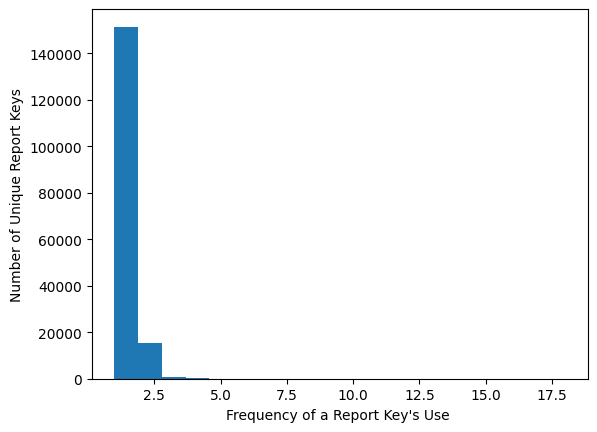

In [ ]:
plt.hist(crime_data['REPORT_KEY'].value_counts().values,bins=19)
plt.xlabel("Frequency of a Report Key's Use ")
plt.ylabel('Number of Unique Report Keys')
plt.show()

In [ ]:
crime_data[crime_data['REPORT_KEY']=='20000006']

,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2,EXTRA_3
81694,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
81756,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
81763,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
81764,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
81965,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
81988,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
82003,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
82211,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
82239,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
82392,Largo PD,12/31/2019,03:47:00AM,20000006,0810,ASSAULT,2200 Block of EAST BAY DR,LARGO,33771.0,NaN,NaN,NaN


In [ ]:
crime_data[crime_data['REPORT_KEY']=='20000273']

,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2,EXTRA_3
81717,Largo PD,1/8/2020,11:09:00 PM,20000273,0630,THEFT-SHOPLIFTING,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
81755,Largo PD,1/8/2020,11:09:00 PM,20000273,0630,THEFT-SHOPLIFTING,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
81811,Largo PD,1/8/2020,11:09:00 PM,20000273,4010,TRAFFIC ACCIDENT,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
81929,Largo PD,1/8/2020,11:09:00 PM,20000273,0630,THEFT-SHOPLIFTING,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
81979,Largo PD,1/8/2020,11:09:00 PM,20000273,4010,TRAFFIC ACCIDENT,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
82013,Largo PD,1/8/2020,11:09:00 PM,20000273,0630,THEFT-SHOPLIFTING,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
82197,Largo PD,1/8/2020,11:09:00 PM,20000273,4010,TRAFFIC ACCIDENT,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
82220,Largo PD,1/8/2020,11:09:00 PM,20000273,0630,THEFT-SHOPLIFTING,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
82231,Largo PD,1/8/2020,11:09:00 PM,20000273,4010,TRAFFIC ACCIDENT,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
82233,Largo PD,1/8/2020,11:09:00 PM,20000273,4010,TRAFFIC ACCIDENT,NaN,CLEARWATER,33770.0,NaN,NaN,NaN


73540 unique report keys suggests to me that it is a identifier. Looking at records related to a report key('20000273), I see 18 records with all the same date,offense start time, agency, and location. The main difference is that 9 are coded as TRAFFIC ACCIDENT (4010) and 9 are coded as THEFT-SHOPLIFTING (0630).

I need to contact the Sheriff's Office where this information comes from to get better definitions

I might need to drop duplicates.

REPORT_DATE and OFFENSE_START_TIME should be considered datetime datatypes.

In [ ]:
crime_data['REPORT_DATE'] = pd.to_datetime(crime_data['REPORT_DATE'],format='%m/%d/%Y')

REPORT_DATE was easy. OFFENSE_START_TIME has some mixed formats and strings in it.

In [ ]:
crime_data['OFFENSE_START_TIME'].value_counts()

,count
OFFENSE_START_TIME,
Unknown,10711
12:00:00AM,6555
12:00:00 PM,3527
12:00:00 AM,3286
08:00:00 AM,2375
...,...
12: 03: 00PM,1
11: 23: 00PM,1
08: 48: 00PM,1


Notice that some times have whitespace mixed into the time and AM/PM. Let's try to strip any whitespace out.

In [ ]:
crime_data['OFFENSE_START_TIME']=crime_data['OFFENSE_START_TIME'].str.replace(' ',"")

In [ ]:
crime_data['OFFENSE_START_TIME'].value_counts()

,count
OFFENSE_START_TIME,
Unknown,10711
12:00:00AM,9903
12:00:00PM,5491
08:00:00AM,3497
06:00:00PM,3350
...,...
05:59:00AM,10
05:06:00AM,10
07:02:00AM,8


That reduced things a little bit. Instead of 2061 unique times, there is now 1441 unique times. Still need to remove 'Unknown' so that it can be converted to 'NaT

In [ ]:
crime_data.loc[crime_data['OFFENSE_START_TIME']=='Unknown','OFFENSE_START_TIME'] = np.nan
crime_data['OFFENSE_START_TIME'].value_counts()

,count
OFFENSE_START_TIME,
12:00:00AM,9903
12:00:00PM,5491
08:00:00AM,3497
06:00:00PM,3350
05:00:00PM,3347
...,...
05:48:00AM,10
05:06:00AM,10
07:02:00AM,8


Look at that number of rows! That would match to a report for every minute the day.

In [ ]:
crime_data['OFFENSE_START_TIME'] = pd.to_datetime(crime_data['OFFENSE_START_TIME'],format='%I:%M:%S%p',exact=True).dt.time

I don't think keeping the OFFENSE_START_TIME information will be important in the long run.

In [ ]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186026 entries, 0 to 186025
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   AGENCY_ID           186026 non-null  object        
 1   REPORT_DATE         186026 non-null  datetime64[ns]
 2   OFFENSE_START_TIME  175315 non-null  object        
 3   REPORT_KEY          186026 non-null  object        
 4   REPORT_CODE         186026 non-null  object        
 5   CATEGORY            186026 non-null  category      
 6   BLOCK_ADDRESS       170583 non-null  object        
 7   CITY                185657 non-null  object        
 8   ZIP                 178494 non-null  object        
 9   EXTRA_1             327 non-null     object        
 10  EXTRA_2             80 non-null      object        
 11  EXTRA_3             1 non-null       float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(9)
memory usage: 15.8+ MB


I want to see if there is an uneven distribustion of crime across the years. Are the records maybe only reporting weekdays or something weird like that?

In [ ]:
year2020 = crime_data[crime_data['REPORT_DATE'].dt.year==2020]

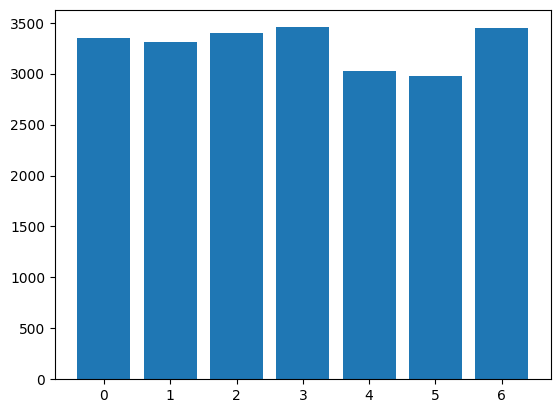

In [ ]:
plt.bar(x=year2020['REPORT_DATE'].dt.day_of_week.value_counts().index,height=year2020['REPORT_DATE'].dt.day_of_week.value_counts().values)
plt.show()

For 2020, it seems that there are less crimes reported on Friday and Saturday. Is this just random? Exact days for analysis doesn't likely matter in the long run.

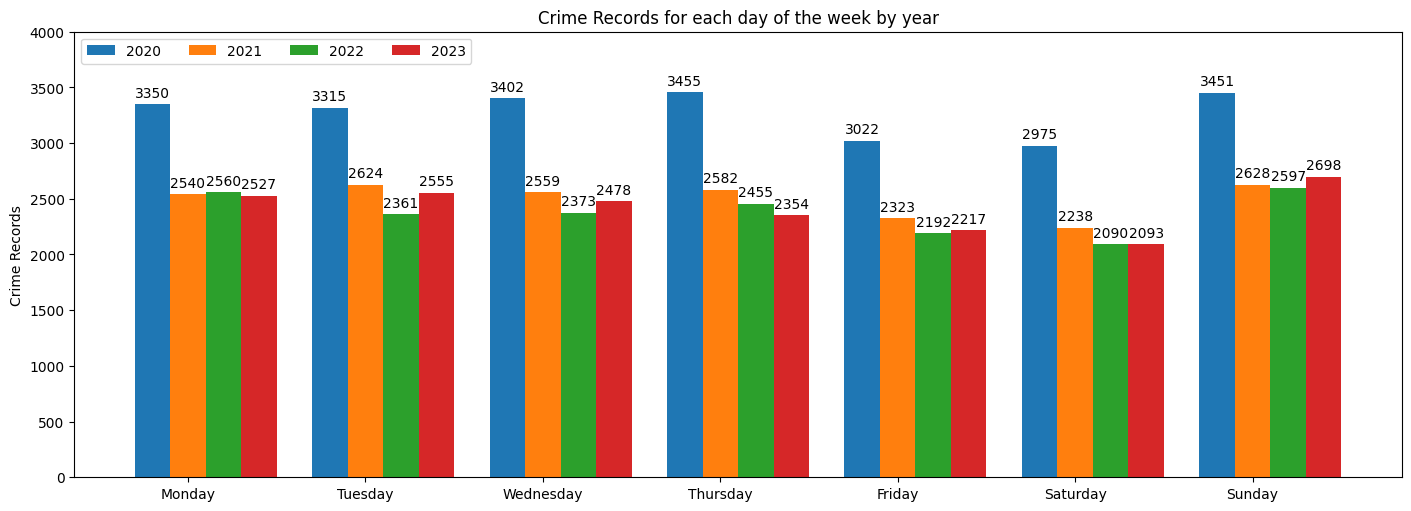

In [ ]:
days_of_week = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

years = [2020,2021,2022,2023] #The list of years I will focus on here. 2024 data should be shorter because it is missing half of the year.
crime_counts = {}
for year in years:
  date_data=[]
  for date,name in days_of_week.items():
    date_data.append(crime_data[(crime_data['REPORT_DATE'].dt.year==year)&(crime_data['REPORT_DATE'].dt.day_of_week==date)].shape[0])
  crime_counts[year]=date_data

#print(crime_counts)

x = np.arange(len(days_of_week))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for year, measurement in crime_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=year)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Crime Records')
ax.set_title('Crime Records for each day of the week by year')
ax.set_xticks(x + width, days_of_week.values())
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0,4000)
fig.set_figwidth(14)
fig.set_figheight(5)
plt.show()


Okay, so there are more records of crime in 2020 than in 2021,2022,or 2023.
I will have to expand this graph in the future after I get records further back in time.

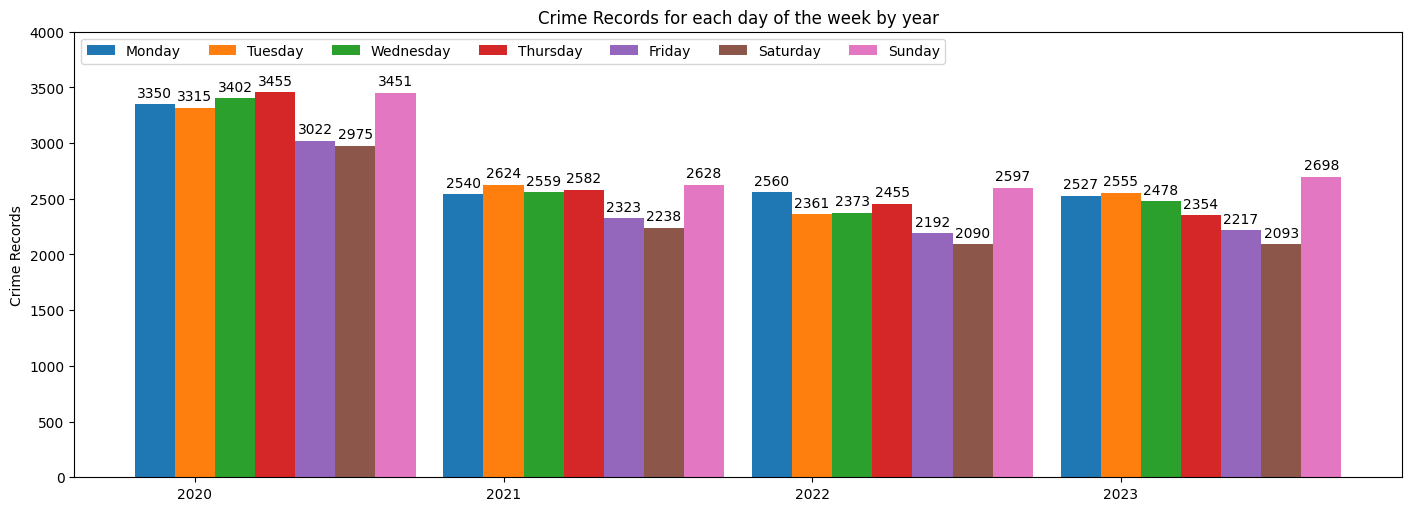

In [ ]:
days_of_week = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

years = [2020,2021,2022,2023] #The list of years I will focus on here. 2024 data should be shorter because it is missing half of the year.
crime_counts = {}
for date,name in days_of_week.items():
  date_data=[]
  for year in years:
    date_data.append(crime_data[(crime_data['REPORT_DATE'].dt.year==year)&(crime_data['REPORT_DATE'].dt.day_of_week==date)].shape[0])
  crime_counts[name]=date_data

#print(crime_counts)

x = np.arange(len(years))  # the label locations
width = 0.13  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for name, measurement in crime_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=name)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Crime Records')
ax.set_title('Crime Records for each day of the week by year')
ax.set_xticks(x + width, years)
ax.legend(loc='upper left', ncols=7)
ax.set_ylim(0,4000)
fig.set_figwidth(14)
fig.set_figheight(5)
plt.show()


Seems like all of the graphs have a slight drop in crime on Friday and Saturday before spiking again on Sunday.

###CITY, ZIP and the EXTRA columns

Cleaning up the city names and zip codes. Sometimes the city name is repeated in the zip and the zip is in EXTRA_1. Sometimes there is a city in EXTRA_1 and a zip in EXTRA_2.

All the zips will need to be integers before being combined with the city in a string. This will be so that the city/zip matches the SITE_CITYZIP in the PCPAO_SalesDATA.

In [ ]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186026 entries, 0 to 186025
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   AGENCY_ID           186026 non-null  object        
 1   REPORT_DATE         186026 non-null  datetime64[ns]
 2   OFFENSE_START_TIME  175315 non-null  object        
 3   REPORT_KEY          186026 non-null  object        
 4   REPORT_CODE         186026 non-null  object        
 5   CATEGORY            186026 non-null  category      
 6   BLOCK_ADDRESS       170583 non-null  object        
 7   CITY                185657 non-null  object        
 8   ZIP                 178494 non-null  object        
 9   EXTRA_1             327 non-null     object        
 10  EXTRA_2             80 non-null      object        
 11  EXTRA_3             1 non-null       float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(9)
memory usage: 15.8+ MB


The CITY and ZIP columns will be best used as string columns for now.
I will strip the columns of whitespace to make them easier to compare(hopefully).

EXTRA_1 and EXTRA_2 need the same treatment.

I don't want to convert np.nan into 'nan' so, I will filter to only focus on not-na values.

In [ ]:
#Some of the CITY column values have whitespace.
#Converting all of the non-NaN values in EXTRA_1 & EXTRA_2 columns to strings and stripping of whitespace as well
crime_data['CITY']=crime_data[crime_data['CITY'].notna()]['CITY'].astype(str).str.strip()
crime_data['ZIP']=crime_data[crime_data['ZIP'].notna()]['ZIP'].astype(str).str.strip()
crime_data['EXTRA_1']=crime_data[crime_data['EXTRA_1'].notna()]['EXTRA_1'].astype(str).str.strip()
crime_data['EXTRA_2']=crime_data[crime_data['EXTRA_2'].notna()]['EXTRA_2'].astype(str).str.strip()

In [ ]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186026 entries, 0 to 186025
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   AGENCY_ID           186026 non-null  object        
 1   REPORT_DATE         186026 non-null  datetime64[ns]
 2   OFFENSE_START_TIME  175315 non-null  object        
 3   REPORT_KEY          186026 non-null  object        
 4   REPORT_CODE         186026 non-null  object        
 5   CATEGORY            186026 non-null  category      
 6   BLOCK_ADDRESS       170583 non-null  object        
 7   CITY                185657 non-null  object        
 8   ZIP                 178494 non-null  object        
 9   EXTRA_1             327 non-null     object        
 10  EXTRA_2             80 non-null      object        
 11  EXTRA_3             1 non-null       float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(9)
memory usage: 15.8+ MB


###Going to start by examining/fixing the one row that has a value in EXTRA_3

In [ ]:
crime_data[crime_data['EXTRA_3'].notna()]

,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2,EXTRA_3
76784,Sheriff,2020-03-24,21:30:00,so20-92195,PT,THEFT-PETIT,8300 Block of BAYOU BOARDWALK,APT 801,SEMINOLE,,PINELLAS SO,33777.0


EXTRA_1 is null, EXTRA_2 is Pinellas SO(I think this means pinesllas sheriff's office), and EXTRA_3 is the zip code.
CITY is the apartment number while ZIP is the CITY. I just need to adjust some of these.
I will make the CITY=SEMINOLE and the ZIP=33777. I will make extra_1,extra_2, and extra_3 null.

WHAT IS THAT OFFENSE_START_TIME ??? It has a date and military time. NOT what I expect to see there.

In [ ]:
crime_data.iloc[76784,crime_data.columns.get_loc('ZIP')] = 33777
crime_data.iloc[76784,crime_data.columns.get_loc('CITY')] = 'SEMINOLE'
crime_data.iloc[76784,crime_data.columns.get_loc('EXTRA_1')] = np.nan
crime_data.iloc[76784,crime_data.columns.get_loc('EXTRA_2')] = np.nan
crime_data.iloc[76784,crime_data.columns.get_loc('EXTRA_3')] = np.nan
crime_data.iloc[76784,:]

,76784
AGENCY_ID,Sheriff
REPORT_DATE,2020-03-24 00:00:00
OFFENSE_START_TIME,21:30:00
REPORT_KEY,so20-92195
REPORT_CODE,PT
CATEGORY,THEFT-PETIT
BLOCK_ADDRESS,8300 Block of BAYOU BOARDWALK
CITY,SEMINOLE
ZIP,33777
EXTRA_1,NaN


In [ ]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186026 entries, 0 to 186025
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   AGENCY_ID           186026 non-null  object        
 1   REPORT_DATE         186026 non-null  datetime64[ns]
 2   OFFENSE_START_TIME  175315 non-null  object        
 3   REPORT_KEY          186026 non-null  object        
 4   REPORT_CODE         186026 non-null  object        
 5   CATEGORY            186026 non-null  category      
 6   BLOCK_ADDRESS       170583 non-null  object        
 7   CITY                185657 non-null  object        
 8   ZIP                 178494 non-null  object        
 9   EXTRA_1             326 non-null     object        
 10  EXTRA_2             79 non-null      object        
 11  EXTRA_3             0 non-null       float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(9)
memory usage: 15.8+ MB


EXTRA_3 is now all null. Perfect to drop and then inspect rows with non-null EXTRA_2 columns.


###Working on columns with non-null EXTRA_2

In [ ]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186026 entries, 0 to 186025
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   AGENCY_ID           186026 non-null  object        
 1   REPORT_DATE         186026 non-null  datetime64[ns]
 2   OFFENSE_START_TIME  175315 non-null  object        
 3   REPORT_KEY          186026 non-null  object        
 4   REPORT_CODE         186026 non-null  object        
 5   CATEGORY            186026 non-null  category      
 6   BLOCK_ADDRESS       170583 non-null  object        
 7   CITY                185657 non-null  object        
 8   ZIP                 178494 non-null  object        
 9   EXTRA_1             326 non-null     object        
 10  EXTRA_2             79 non-null      object        
 11  EXTRA_3             0 non-null       float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(9)
memory usage: 15.8+ MB


In [ ]:
crime_data.drop(['EXTRA_3'],axis=1,inplace=True)

####Cleaning process.
* Examine the first value that is non-na in the EXTRA_2 column
* Identify a feature to select on that gets the first value(not index value)
* Target the feature to see what other records come up.
* If all the records targeted have the same problem, fix the problem in the #Make Changes cell
* If all the records don't have the same problem, narrow the target some more.
* Record all changes that are done in the #Make Changes cell in the #Record Changes Here Cell
* Repeat process with EXTRA_1 column

In [ ]:
crime_data[crime_data['EXTRA_1'].notna()]

,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2
373,Sheriff,2024-05-16,17:30:00,SO24-150505,CMF,VANDAL/CRIM MISCH,500 Block of ALT 19,UNINCORPORATED,PINELLAS SO,34698.0,NaN
609,Tarpon Springs PD,2024-05-28,12:16:00,TS24-16609,LSAP,TRAFFIC ACCIDENT,ALT 19 & E TARPON AVE,TARPON SPRINGS,TARPON SPRINGS,34689.0,NaN
1384,Sheriff,2024-06-22,21:37:00,SO24-192824,PT,THEFT-PETIT,700 Block of ALT 19,PALM HARBOR,34683.0,PINELLAS SO,34683.0
1680,Sheriff,2024-06-22,21:37:00,SO24-192824,PT,THEFT-PETIT,700 Block of ALT 19,PALM HARBOR,34683.0,PINELLAS SO,34683.0
2269,Tarpon Springs PD,2024-03-10,10:29:00,TS24-7817,LSAP,TRAFFIC ACCIDENT,ALT 19 & MERES BLVD,TARPON SPRINGS,346.0,TARPON SPRINGS,34689.0
...,...,...,...,...,...,...,...,...,...,...,...
176693,Largo PD,2016-05-11,NaT,16005134,0690,THEFT-PETIT,NaN,CLEARWATER,NaN,33760.0,NaN
176849,Largo PD,2016-05-11,03:30:00,16005134,0690,THEFT-PETIT,1900 Block of BROOKSTONE WAY,CLEARWATER,NaN,33760.0,NaN
177774,Largo PD,2016-04-28,NaT,16004669,0520,BURGLARY-STRUCTURE,NaN,CLEARWATER,NaN,33764.0,NaN
177776,Largo PD,2016-04-28,NaT,16004697,0520,BURGLARY-STRUCTURE,NaN,CLEARWATER,NaN,33756.0,NaN


I am going to have to tailor some of these fixes. I will make all the fixes in indiviual codes. I will then copy the fixing codes into a designated cell that can be run when going through the notebook.

In [ ]:
#See what is being targeted here
#for example:
crime_data[crime_data['EXTRA_1']=='33765']

,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2
73880,Clearwater PD,2020-05-15,NaT,CW20-71031,LSAP,TRAFFIC ACCIDENT,GULF TO BAY BLVD & BYPASS DR,CLEARWATER,CLEARWATER,33765,NaN


In [ ]:
#make changes here
#The record here has '33765' in EXTRA_1.
#CITY will stay CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33765
temp_index = crime_data[crime_data['EXTRA_1']=='33765'].index
crime_data.loc[temp_index,'ZIP']='33765'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan


####EXTRA_2 fixes

Running this will run a set of data cleaning to a make the EXTRA_2 column all null values. Other values like CITY, ZIP, and EXTRA_1 will be cleaned some as well.

**Only valid for data from JAN 1st, 2020 to JULY 22nd, 2024.**

**When data prior to 2020 is included, this will need to be fixed up again**

In [ ]:
#Record the changes here.
#If the CITY column and EXTRA_1 column match, then the EXTRA_1 column can be set to np.nan
temp_index = crime_data[crime_data['CITY']==crime_data['EXTRA_1']]
crime_data.loc[temp_index.index,'EXTRA_1']=np.nan

#If ZIP matches EXTRA_2, then the extra_2 can be np.nan
temp_index = crime_data[crime_data['EXTRA_2']==crime_data['ZIP']].index
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#Fixing zip codes and clearing extra_2 in Tarpon Springs
temp_index = crime_data[crime_data['EXTRA_2']=='34689.0'].index
crime_data.loc[temp_index,'ZIP']='34689'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#Dunedin locations with EXTRA_2=34698.0 have correct city, zip.
#EXTRA values are cleared out.
temp_index = crime_data[crime_data['EXTRA_2']=='34698.0'].index
crime_data.loc[temp_index,'ZIP']='34698'
crime_data.loc[temp_index,'CITY']='DUNEDIN'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#CROSSING OF COURTNEY CAMPBELL CSWY
temp_index = crime_data[crime_data['BLOCK_ADDRESS']=='COURTNEY CAMPBELL CSWY'].index
crime_data.loc[temp_index,'ZIP']='33759'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This set has UNINCORPORATED and PALM HARBOR for CITY values
#The ZIP 34683 matches EXTRA_2. Need to clearout the EXTRA columns
temp_index = crime_data[(crime_data['ZIP']=='34683')&(crime_data['EXTRA_2']=='34683.0')].index
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This location needed ZIP added from EXTRA_2
#Need to clearout the EXTRA columns
temp_index = crime_data[crime_data['EXTRA_2']=='33773.0'].index
crime_data.loc[temp_index,'ZIP']='33773'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#CITY and ZIP look fine
#Need to clearout the EXTRA columns
temp_index = crime_data[crime_data['EXTRA_2']=='33764.0'].index
crime_data.loc[temp_index,'ZIP']='33764'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#BLOCK_ADDRESS, CITY, ZIP all agree
#Clearing EXTRAs
temp_index = crime_data[crime_data['EXTRA_2']=='33767.0'].index
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This set of data had ZIPs in the EXTRA columns and was mixing CITY names
#CITY name TIERRA VERDE instead of ST PETERSBURG
temp_index = crime_data[crime_data['EXTRA_2']=='33715.0'].index
crime_data.loc[temp_index,'ZIP']='33715'
crime_data.loc[temp_index,'CITY']='TIERRA VERDE'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This BLOCK ADDRESS gives a ST PETERSBURG city
#and 33707 ZIP value.
temp_index = crime_data[crime_data['EXTRA_2']=='33707.0'].index
crime_data.loc[temp_index,'ZIP']='33707'
crime_data.loc[temp_index,'CITY']='ST PETERSBURG'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This temp_index focused on TARPON SPRINGS
#The addresses straddle the line between Tarpon Springs and Palm Harbor
#Going to go with Tarpon Springs as the CITY and ZIP already match address-wise
#ZIP needed fixing on one record. EXTRAs needed clearing
temp_index = crime_data[(crime_data['EXTRA_2']=='34683.0')&(crime_data['CITY']=='TARPON SPRINGS')].index
crime_data.loc[temp_index,'ZIP']='34689'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#Two Madeira Beach records were missing ZIP and had them in EXTRA_2
temp_index = crime_data[crime_data['EXTRA_2']=='33708.0'].index
crime_data.loc[temp_index,'ZIP']='33708'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#Treasure Island BLOCK_ADDRESS, CITY and ZIP line up
#Clear the EXTRAs
temp_index = crime_data[crime_data['EXTRA_2']=='33706.0'].index
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This record has CLEARWATER BEACH as block_address
#CLEARWATER as CITY and AVENUE as ZIP
#Treating this as being on CLEARWATER BEACH
temp_index = crime_data[crime_data['EXTRA_2']=='33759.0'].index
crime_data.loc[temp_index,'ZIP']='33767'
crime_data.loc[temp_index,'CITY']='CLEARWATER BEACH'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This UNINCORPORATED record would have PALM HARBOR as the CITY
#Then the ZIP in EXTRA_2 would make sense
temp_index = crime_data[(crime_data['EXTRA_2']=='34683.0')&(crime_data['CITY']=='UNINCORPORATED')].index
crime_data.loc[temp_index,'ZIP']='34683'
crime_data.loc[temp_index,'CITY']='PALM HARBOR'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan


crime_data.drop(['EXTRA_2'],axis=1,inplace=True)

####EXTRA_1 Fixes
After all of the EXTRA_2 column is NaN,
 work to make all the EXTRA_1 column NaN

In [ ]:
#Recording fixes for EXTRA_1 Here

#The records here all have the ZIP in EXTRA_1
#Almost every single ZIP and CITY is DUNEDIN
#Then a couple are UNINCORPORATED and PINELLAS SO
temp_index = crime_data[crime_data['EXTRA_1']=='34698.0'].index
crime_data.loc[temp_index,'ZIP']='34698'
crime_data.loc[temp_index,'CITY']='DUNEDIN'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have the ZIP in EXTRA_1
#Almost every single CITY and ZIP is TARPON SPRINGS
#Then a couple are TARPON SPRINGS and PINELLAS SO
temp_index = crime_data[crime_data['EXTRA_1']=='34689.0'].index
crime_data.loc[temp_index,'ZIP']='34689'
crime_data.loc[temp_index,'CITY']='TARPON SPRINGS'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have PINELLAS SO in EXTRA_1
#Almost every single CITY is PALM HARBOR
#A couple CITY values are UNINCORPORATED, which will get replaced by PALM HARBOR
#ZIPs need to be fixed to not have '.0'
temp_index = crime_data[crime_data['EXTRA_1']=='PINELLAS SO'].index
crime_data.loc[temp_index,'ZIP']='34683'
crime_data.loc[temp_index,'CITY']='PALM HARBOR'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33764.0' in EXTRA_1
#Every single CITY is CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33764
temp_index = crime_data[crime_data['EXTRA_1']=='33764.0'].index
crime_data.loc[temp_index,'ZIP']='33764'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '34689' in EXTRA_1
#Every single CITY is TARPON SPRINGS
#ZIPs need to be fixed from TARPON SPRINGS to 34689
temp_index = crime_data[crime_data['EXTRA_1']=='34689'].index
crime_data.loc[temp_index,'ZIP']='34689'
crime_data.loc[temp_index,'CITY']='TARPON SPRINGS'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33715.0' in EXTRA_1
#Every single CITY is ST PETERSBURG
#ZIPs need to be fixed from ST PETERSBURG to 33715
temp_index = crime_data[crime_data['EXTRA_1']=='33715.0'].index
crime_data.loc[temp_index,'ZIP']='33715'
crime_data.loc[temp_index,'CITY']='ST PETERSBURG'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33708.0' in EXTRA_1
#CITY needs to be fixed from MADEIRA to MADEIRA BEACH
#ZIPs need to be fixed from MADEIRA BEACH to 33708
temp_index = crime_data[crime_data['EXTRA_1']=='33708.0'].index
crime_data.loc[temp_index,'ZIP']='33708'
crime_data.loc[temp_index,'CITY']='MADEIRA BEACH'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '34683.0' in EXTRA_1
#CITY needs to be fixed from UNINCORPORATED to PALM HARBOR
#ZIPs need to be fixed from PINELLAS SO to 34683
temp_index = crime_data[crime_data['EXTRA_1']=='34683.0'].index
crime_data.loc[temp_index,'ZIP']='34683'
crime_data.loc[temp_index,'CITY']='PALM HARBOR'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '34677.0' in EXTRA_1
#CITY needs to be fixed from FL to OLDSMAR
#ZIPs need to be fixed from OLDSMAR to 34677
temp_index = crime_data[crime_data['EXTRA_1']=='34677.0'].index
crime_data.loc[temp_index,'ZIP']='34677'
crime_data.loc[temp_index,'CITY']='OLDSMAR'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '34698' in EXTRA_1
#A CITY record needs to be fixed from UNINCORPORATED to DUNEDIN
#ZIPs need to be fixed from DUNEDIN to 34698
temp_index = crime_data[crime_data['EXTRA_1']=='34698'].index
crime_data.loc[temp_index,'ZIP']='34698'
crime_data.loc[temp_index,'CITY']='DUNEDIN'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33715' in EXTRA_1
#ZIPs need to be fixed from ST PETERSBURG to 33715
temp_index = crime_data[(crime_data['EXTRA_1']=='33715')&(crime_data['CITY']=='ST PETERSBURG')].index
crime_data.loc[temp_index,'ZIP']='33715'
crime_data.loc[temp_index,'CITY']='ST PETERSBURG'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '34683' in EXTRA_1
#CITY is UNINCORPORATED. Will change to PALM HARBOR
#ZIPs need to be fixed from PINELLAS SO to 34683
temp_index = crime_data[crime_data['EXTRA_1']=='34683'].index
crime_data.loc[temp_index,'ZIP']='34683'
crime_data.loc[temp_index,'CITY']='PALM HARBOR'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33715' in EXTRA_1
#CITY is UNIN. Will change to TIERRA VERDE
#ZIPs need to be fixed from PINELLAS SO to 33715
temp_index = crime_data[crime_data['EXTRA_1']=='33715'].index
crime_data.loc[temp_index,'ZIP']='33715'
crime_data.loc[temp_index,'CITY']='TIERRA VERDE'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33761.0' in EXTRA_1
#CITY is CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33761
temp_index = crime_data[crime_data['EXTRA_1']=='33761.0'].index
crime_data.loc[temp_index,'ZIP']='33761'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33707.0' in EXTRA_1
#CITY is blank. Will fix to GULFPORT
#ZIPs need to be fixed from GULFPORT to 33707
temp_index = crime_data[(crime_data['EXTRA_1']=='33707.0')&(crime_data['ZIP']=='GULFPORT')].index
crime_data.loc[temp_index,'ZIP']='33707'
crime_data.loc[temp_index,'CITY']='GULFPORT'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33707.0' in EXTRA_1
#CITY is SOUTH PASADENA
#ZIPs need to be fixed from SOUTH PASADENA to 33707
temp_index = crime_data[(crime_data['EXTRA_1']=='33707.0')&(crime_data['ZIP']=='SOUTH PASADENA')].index
crime_data.loc[temp_index,'ZIP']='33707'
crime_data.loc[temp_index,'CITY']='SOUTH PASADENA'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33756' in EXTRA_1
#CITYs need to be fixed from FL to CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33756
temp_index = crime_data[crime_data['EXTRA_1']=='33756'].index
crime_data.loc[temp_index,'ZIP']='33756'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33755.0' in EXTRA_1
#CITY is CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33755
temp_index = crime_data[crime_data['EXTRA_1']=='33755.0'].index
crime_data.loc[temp_index,'ZIP']='33755'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33710.0' in EXTRA_1
#CITY is ST PETERSBURG
#ZIPs need to be fixed from ST PETERSBURG to 33710
temp_index = crime_data[crime_data['EXTRA_1']=='33710.0'].index
crime_data.loc[temp_index,'ZIP']='33710'
crime_data.loc[temp_index,'CITY']='ST PETERSBURG'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33763.0' in EXTRA_1
#CITY needs to be fixed from blank to CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33763
temp_index = crime_data[crime_data['EXTRA_1']=='33763.0'].index
crime_data.loc[temp_index,'ZIP']='33763'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33707' in EXTRA_1 & SOUTH PASADENA in ZIP
#CITY is SOUTH PASADENA
#ZIPs need to be fixed from SOUTH PASADENA to 33707
temp_index = crime_data[(crime_data['EXTRA_1']=='33707')&(crime_data['ZIP']=='SOUTH PASADENA')].index
crime_data.loc[temp_index,'ZIP']='33707'
crime_data.loc[temp_index,'CITY']='SOUTH PASADENA'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33706.0' in EXTRA_1
#CITY needs to be fixed from 100 BLK 107TH AVE to TREASURE ISLAND
#ZIPs need to be fixed from TREASURE ISLAND to 33706
temp_index = crime_data[crime_data['EXTRA_1']=='33706.0'].index
crime_data.loc[temp_index,'ZIP']='33706'
crime_data.loc[temp_index,'CITY']='TREASURE ISLAND'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The two records here all have '33755' in EXTRA_1.
#CITY will stay DUNEDIN
#ZIPs need to be fixed from CLEARWATER and DUNEDIN to 33755
temp_index = crime_data[crime_data['EXTRA_1']=='33755'].index
crime_data.loc[temp_index,'ZIP']='33755'
crime_data.loc[temp_index,'CITY']='DUNEDIN'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The two records here all have '33764' in EXTRA_1.
#CITY will stay CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33764
temp_index = crime_data[crime_data['EXTRA_1']=='33764'].index
crime_data.loc[temp_index,'ZIP']='33764'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The two records here all have '33707' in EXTRA_1.
#CITY needs to be fixed from blank to GULFPORT
#ZIPs need to be fixed from GULFPORT to 33707
temp_index = crime_data[crime_data['EXTRA_1']=='33707'].index
crime_data.loc[temp_index,'ZIP']='33707'
crime_data.loc[temp_index,'CITY']='GULFPORT'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The record here has '33765' in EXTRA_1.
#CITY will stay CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33765
temp_index = crime_data[crime_data['EXTRA_1']=='33765'].index
crime_data.loc[temp_index,'ZIP']='33765'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

crime_data.drop(['EXTRA_1'],axis=1,inplace=True)


#4. Exporting Data

Here I will export the cleaned data for the PCPAO_SalesDATA and for sales16 into their own csv files.

In [96]:
PCPAO_SalesDATA.to_csv('/content/drive/MyDrive/Data Science Course/Capstone Work/Cleaned_Data/PCPAO_SalesDATA_cleaned.csv',index=False)


In [97]:
sales16.to_csv('/content/drive/MyDrive/Data Science Course/Capstone Work/Cleaned_Data/sales16_cleaned.csv',index=False)